# Genus and Metabolite 115+203 Merged Data Processing

This notebook processes genus data and the merged metabolite data (115+203) for allergy prediction (IgE vs. N).
We will:
1. Load genus data and metabolite_115_203_merged_ml_format data
2. Remove nE samples (duplicates)
3. Merge the datasets based on common samples
4. Add prefixes to distinguish between genus and metabolite features
5. Prepare data for machine learning

**Output**: `genus_metabolite_115_203_merged_ml_format.xlsx` with genus_ and metabolite_ prefixed features

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load the Data

In [39]:
# Load genus data (this file is tab-separated despite .xls extension)
genus_file = 'DZOE2024090259_售后分析结果.20265.06.27_4cW0iTSH/genus.xls'
genus_data = pd.read_csv(genus_file, sep='\t', index_col=0)

print(f"Genus data shape: {genus_data.shape}")
print(f"Genus data columns (first 10): {list(genus_data.columns[:10])}")
print(f"Genus data index (first 5): {list(genus_data.index[:5])}")
print(f"Total genus features: {genus_data.shape[0]}")

Genus data shape: (567, 374)
Genus data columns (first 10): ['N-4', 'N-5', 'N-12', 'N-13', 'N-16', 'N-18', 'N-19', 'N-24', 'N-26', 'N-28']
Genus data index (first 5): ['Escherichia-Shigella', 'Bifidobacterium', 'Klebsiella', 'Bacteroides', 'Clostridium_sensu_stricto_1']
Total genus features: 567


In [40]:
# Load the merged metabolite data (115+203)
metabolite_file = 'metabolite_115_203_merged_ml_format.xlsx'
try:
    # Try with openpyxl engine first (for .xlsx files)
    metabolite_data_raw = pd.read_excel(metabolite_file, index_col=0, engine='openpyxl')
    print("Loaded with openpyxl engine")
except Exception as e:
    print(f"openpyxl failed: {e}")
    try:
        # If openpyxl fails, try xlrd
        metabolite_data_raw = pd.read_excel(metabolite_file, index_col=0, engine='xlrd')
        print("Loaded with xlrd engine")
    except Exception as e2:
        print(f"xlrd also failed: {e2}")
        # Last resort: try reading as tab-separated values
        metabolite_data_raw = pd.read_csv(metabolite_file, sep='\t', index_col=0)
        print("Loaded as tab-separated file")

print(f"Raw metabolite data shape: {metabolite_data_raw.shape}")
print(f"Samples are in: {'INDEX' if any(s.startswith(('N-', 'IgE-', 'nE-')) for s in metabolite_data_raw.index) else 'COLUMNS'}")

# Check if we need to transpose to match genus data structure
if any(s.startswith(('N-', 'IgE-', 'nE-')) for s in metabolite_data_raw.index):
    # Samples are in index, need to transpose to match genus structure (samples in columns)
    print("Transposing metabolite data to match genus structure...")
    metabolite_data = metabolite_data_raw.T
    print(f"After transpose: {metabolite_data.shape}")
else:
    # Samples are already in columns
    metabolite_data = metabolite_data_raw
    print("No transpose needed")

print(f"Final metabolite data shape: {metabolite_data.shape}")
print(f"Metabolite data columns (first 10): {list(metabolite_data.columns[:10])}")
print(f"Metabolite data index (first 5): {list(metabolite_data.index[:5])}")
print(f"Total metabolite features: {metabolite_data.shape[0]}")

# Note: Keeping 'data_source' in the data as requested

Loaded with openpyxl engine
Raw metabolite data shape: (291, 287)
Samples are in: INDEX
Transposing metabolite data to match genus structure...
After transpose: (287, 291)
Final metabolite data shape: (287, 291)
Metabolite data columns (first 10): ['IgE-121', 'IgE-132', 'IgE-74', 'IgE-87', 'IgE-88', 'IgE-42', 'IgE-65', 'IgE-68', 'IgE-37', 'IgE-37']
Metabolite data index (first 5): ['data_source', '(-)-Malyngolide', '(2-hydroxy-5-prop-2-enylphenyl) hydrogen sulate', '(2E,8E)-10-hydroxydeca-2,8-dien-4-ynoylcarnitine', '(2R,3R,4R)-Hexane-1,2,3,4,6-pentol']
Total metabolite features: 287


## 2. Analyze Sample Names and Labels

In [41]:
# Analyze sample names in genus data
genus_samples = list(genus_data.columns)
print(f"Total genus samples: {len(genus_samples)}")

# Count different sample types
n_samples = [s for s in genus_samples if s.startswith('N-')]
ige_samples = [s for s in genus_samples if s.startswith('IgE-')]
ne_samples = [s for s in genus_samples if s.startswith('nE-')]

print(f"Genus - N samples: {len(n_samples)}")
print(f"Genus - IgE samples: {len(ige_samples)}")
print(f"Genus - nE samples: {len(ne_samples)}")

print(f"\nFirst 5 N samples: {n_samples[:5]}")
print(f"First 5 IgE samples: {ige_samples[:5]}")
print(f"First 5 nE samples: {ne_samples[:5]}")

Total genus samples: 374
Genus - N samples: 193
Genus - IgE samples: 139
Genus - nE samples: 42

First 5 N samples: ['N-4', 'N-5', 'N-12', 'N-13', 'N-16']
First 5 IgE samples: ['IgE-7', 'IgE-14', 'IgE-17', 'IgE-23', 'IgE-27']
First 5 nE samples: ['nE-40', 'nE-61', 'nE-185', 'nE-228', 'nE-347']


In [42]:
# Analyze sample names in metabolite merged data (now correctly structured)
metabolite_samples = list(metabolite_data.columns)
print(f"Total metabolite merged samples: {len(metabolite_samples)}")

# Count different sample types in metabolite data
met_n_samples = [s for s in metabolite_samples if s.startswith('N-')]
met_ige_samples = [s for s in metabolite_samples if s.startswith('IgE-')]
met_ne_samples = [s for s in metabolite_samples if s.startswith('nE-')]

print(f"Metabolite - N samples: {len(met_n_samples)}")
print(f"Metabolite - IgE samples: {len(met_ige_samples)}")
print(f"Metabolite - nE samples: {len(met_ne_samples)}")

print(f"\nFirst 5 metabolite samples: {metabolite_samples[:5]}")
if len(met_n_samples) > 0:
    print(f"First 5 N samples: {met_n_samples[:5]}")
if len(met_ige_samples) > 0:
    print(f"First 5 IgE samples: {met_ige_samples[:5]}")
if len(met_ne_samples) > 0:
    print(f"First 5 nE samples: {met_ne_samples[:5]}")
else:
    print("No nE samples found in metabolite data")

Total metabolite merged samples: 291
Metabolite - N samples: 151
Metabolite - IgE samples: 140
Metabolite - nE samples: 0

First 5 metabolite samples: ['IgE-121', 'IgE-132', 'IgE-74', 'IgE-87', 'IgE-88']
First 5 N samples: ['N-118', 'N-131', 'N-112', 'N-18', 'N-34']
First 5 IgE samples: ['IgE-121', 'IgE-132', 'IgE-74', 'IgE-87', 'IgE-88']
No nE samples found in metabolite data


In [43]:
# Debug: Check actual data structure in metabolite data
print("=== DEBUGGING METABOLITE DATA STRUCTURE ===")
print(f"Metabolite data shape: {metabolite_data.shape}")
print(f"Columns (features): {list(metabolite_data.columns[:10])}")
print(f"Index (should be samples): {list(metabolite_data.index[:10])}")
print(f"Index (last 10): {list(metabolite_data.index[-10:])}")

# The samples are actually in the INDEX, not columns!
actual_samples = list(metabolite_data.index)
print(f"\nTotal actual samples in index: {len(actual_samples)}")

# Count different sample types from INDEX
met_n_samples_correct = [s for s in actual_samples if s.startswith('N-')]
met_ige_samples_correct = [s for s in actual_samples if s.startswith('IgE-')]
met_ne_samples_correct = [s for s in actual_samples if s.startswith('nE-')]

print(f"Correct analysis from INDEX:")
print(f"N samples: {len(met_n_samples_correct)}")
print(f"IgE samples: {len(met_ige_samples_correct)}")
print(f"nE samples: {len(met_ne_samples_correct)}")

print(f"\nFirst 5 N samples: {met_n_samples_correct[:5]}")
print(f"First 5 IgE samples: {met_ige_samples_correct[:5]}")
print(f"First 5 nE samples: {met_ne_samples_correct[:5]}")

# Check if the data structure is different from genus data
print(f"\nData structure comparison:")
print(f"Genus data: samples in columns, features in rows")
print(f"Metabolite data: samples in rows (index), features in columns")
print(f"We need to transpose the metabolite data to match genus structure!")

=== DEBUGGING METABOLITE DATA STRUCTURE ===
Metabolite data shape: (287, 291)
Columns (features): ['IgE-121', 'IgE-132', 'IgE-74', 'IgE-87', 'IgE-88', 'IgE-42', 'IgE-65', 'IgE-68', 'IgE-37', 'IgE-37']
Index (should be samples): ['data_source', '(-)-Malyngolide', '(2-hydroxy-5-prop-2-enylphenyl) hydrogen sulate', '(2E,8E)-10-hydroxydeca-2,8-dien-4-ynoylcarnitine', '(2R,3R,4R)-Hexane-1,2,3,4,6-pentol', '(2R,3S,4R,5R,8R,9S,10R,11R)-5-Amino-1,2,3,4,8,9,10,11-octahydroxydodecane-6,7-dione', "(2S,2'S)-Pyrosaccharopine", '(3R)-3-Hydroxy-N-[(3S)-2-oxooxolan-3-yl]butanamide', '(3S,4R,5R)-1,3,4,5,6-Pentahydroxy-1-morpholin-4-ylhexan-2-one', '(3Z,6Z,9Z)-dodeca-3,6,9-trien-1-yl hydrogen sulfate']
Index (last 10): ['Xylometazoline', 'a,b-dihydroxy-isobutyric acid', 'gamma-Aminobutyryllysine', 'gamma-Glutamylleucine', 'gamma-Glutamylmethionine', 'methionine glutamate', 'methyl 15-hydroperoxy-9Z,12Z,16E-octadecatrienoate', 'n-methacryloyl-l-histidine methyl ester', 'stearyl alcohol', 'trans-O-Methylg

## 3. Remove nE Samples (Duplicates)

In [44]:
# Remove nE samples from genus data
genus_clean = genus_data.drop(columns=ne_samples)
print(f"Genus data after removing nE samples: {genus_clean.shape}")

# Remove nE samples from metabolite data
metabolite_clean = metabolite_data.drop(columns=met_ne_samples)
print(f"Metabolite data after removing nE samples: {metabolite_clean.shape}")

Genus data after removing nE samples: (567, 332)
Metabolite data after removing nE samples: (287, 291)


## 4. Find Common Samples Between Datasets

In [45]:
# Find common samples between genus and metabolite data
genus_samples_clean = set(genus_clean.columns)
metabolite_samples_clean = set(metabolite_clean.columns)

common_samples = genus_samples_clean.intersection(metabolite_samples_clean)
print(f"Common samples between datasets: {len(common_samples)}")

# Samples only in genus data
genus_only = genus_samples_clean - metabolite_samples_clean
print(f"Samples only in genus data: {len(genus_only)}")
if len(genus_only) > 0:
    print(f"First 5 genus-only samples: {sorted(list(genus_only))[:5]}")

# Samples only in metabolite data
metabolite_only = metabolite_samples_clean - genus_samples_clean
print(f"Samples only in metabolite data: {len(metabolite_only)}")
if len(metabolite_only) > 0:
    print(f"First 5 metabolite-only samples: {sorted(list(metabolite_only))[:5]}")

print(f"\nFirst 10 common samples: {sorted(list(common_samples))[:10]}")

Common samples between datasets: 281
Samples only in genus data: 51
First 5 genus-only samples: ['IgE-405', 'IgE-481', 'IgE-487', 'IgE-494', 'IgE-502']
Samples only in metabolite data: 4
First 5 metabolite-only samples: ['IgE-101-2', 'IgE-116-2', 'IgE-410', 'N-359']

First 10 common samples: ['IgE-100', 'IgE-101', 'IgE-105', 'IgE-108', 'IgE-109', 'IgE-110', 'IgE-116', 'IgE-121', 'IgE-125', 'IgE-129']


## 5. Create Labels for Common Samples

In [46]:
# Create labels for common samples
# Note: common_samples_list will be updated in the next cell after deduplication
common_samples_list_temp = sorted(list(common_samples))

# Create label mapping: IgE = 1, N = 0
labels_temp = []
for sample in common_samples_list_temp:
    if sample.startswith('IgE-'):
        labels_temp.append(1)  # Allergy positive
    elif sample.startswith('N-'):
        labels_temp.append(0)  # Allergy negative
    else:
        labels_temp.append(-1)  # Unknown (shouldn't happen after cleaning)

labels_df_temp = pd.DataFrame({
    'sample_id': common_samples_list_temp,
    'label': labels_temp,
    'group': ['IgE' if l == 1 else 'N' for l in labels_temp]
})

print(f"Temporary label distribution (before deduplication):")
print(labels_df_temp['group'].value_counts())
print(f"\nFirst 10 labels:")
print(labels_df_temp.head(10))
print("\nNote: Final labels will be created after sample deduplication in the next cell.")

Temporary label distribution (before deduplication):
group
N      147
IgE    134
Name: count, dtype: int64

First 10 labels:
  sample_id  label group
0   IgE-100      1   IgE
1   IgE-101      1   IgE
2   IgE-105      1   IgE
3   IgE-108      1   IgE
4   IgE-109      1   IgE
5   IgE-110      1   IgE
6   IgE-116      1   IgE
7   IgE-121      1   IgE
8   IgE-125      1   IgE
9   IgE-129      1   IgE

Note: Final labels will be created after sample deduplication in the next cell.


## 6. Extract Common Samples from Both Datasets

In [47]:
# Debug: Check if all common samples exist in both datasets
print("=== DEBUGGING COMMON SAMPLES EXTRACTION ===")
print(f"Common samples to extract: {len(common_samples_list)}")
print(f"Available genus samples: {len(genus_clean.columns)}")
print(f"Available metabolite samples: {len(metabolite_clean.columns)}")

# Check for duplicate samples in each dataset
genus_duplicates = genus_clean.columns.duplicated().sum()
metabolite_duplicates = metabolite_clean.columns.duplicated().sum()
print(f"Genus duplicate columns: {genus_duplicates}")
print(f"Metabolite duplicate columns: {metabolite_duplicates}")

if metabolite_duplicates > 0:
    print("Found duplicates in metabolite data!")
    duplicate_samples = genus_clean.columns[genus_clean.columns.duplicated(keep=False)]
    print(f"Duplicate samples: {duplicate_samples.tolist()}")

# Check which common samples are missing from each dataset
missing_from_genus = [s for s in common_samples_list if s not in genus_clean.columns]
missing_from_metabolite = [s for s in common_samples_list if s not in metabolite_clean.columns]

print(f"Missing from genus: {len(missing_from_genus)}")
if missing_from_genus:
    print(f"First 5 missing from genus: {missing_from_genus[:5]}")
    
print(f"Missing from metabolite: {len(missing_from_metabolite)}")
if missing_from_metabolite:
    print(f"First 5 missing from metabolite: {missing_from_metabolite[:5]}")

# Extract only samples that actually exist in both datasets
truly_common_samples = [s for s in common_samples_list 
                       if s in genus_clean.columns and s in metabolite_clean.columns]
print(f"\nTruly common samples (exist in both): {len(truly_common_samples)}")

# Remove duplicates from metabolite data before extraction
print("Removing duplicates from metabolite data...")
metabolite_clean_dedup = metabolite_clean.loc[:, ~metabolite_clean.columns.duplicated()]
print(f"Metabolite data after deduplication: {metabolite_clean_dedup.shape}")

# Extract common samples from genus data
genus_common = genus_clean[truly_common_samples].T  # Transpose to have samples as rows
print(f"Genus common samples shape: {genus_common.shape}")

# Extract common samples from metabolite data
metabolite_common = metabolite_clean_dedup[truly_common_samples].T  # Transpose to have samples as rows
print(f"Metabolite common samples shape: {metabolite_common.shape}")

# Verify sample order is the same
sample_order_matches = list(genus_common.index) == list(metabolite_common.index)
print(f"Sample order matches: {sample_order_matches}")

if not sample_order_matches:
    print("Sample orders don't match! Reordering metabolite data...")
    # Reorder metabolite data to match genus order
    metabolite_common = metabolite_common.reindex(genus_common.index)
    print(f"After reordering - Sample order matches: {list(genus_common.index) == list(metabolite_common.index)}")

print(f"\nFinal shapes:")
print(f"Genus features: {genus_common.shape[1]}")
print(f"Metabolite features: {metabolite_common.shape[1]}")

# Update common_samples_list to the truly common ones
common_samples_list = truly_common_samples
print(f"Updated common_samples_list length: {len(common_samples_list)}")

# Create final labels for the deduplicated common samples
print("\n=== CREATING FINAL LABELS ===")
labels = []
for sample in common_samples_list:
    if sample.startswith('IgE-'):
        labels.append(1)  # Allergy positive
    elif sample.startswith('N-'):
        labels.append(0)  # Allergy negative
    else:
        labels.append(-1)  # Unknown (shouldn't happen after cleaning)

labels_df = pd.DataFrame({
    'sample_id': common_samples_list,
    'label': labels,
    'group': ['IgE' if l == 1 else 'N' for l in labels]
})

print(f"Final label distribution:")
print(labels_df['group'].value_counts())
print(f"Total samples for modeling: {len(labels)}")

=== DEBUGGING COMMON SAMPLES EXTRACTION ===
Common samples to extract: 281
Available genus samples: 332
Available metabolite samples: 291
Genus duplicate columns: 0
Metabolite duplicate columns: 6
Found duplicates in metabolite data!
Duplicate samples: []
Missing from genus: 0
Missing from metabolite: 0

Truly common samples (exist in both): 281
Removing duplicates from metabolite data...
Metabolite data after deduplication: (287, 285)
Genus common samples shape: (281, 567)
Metabolite common samples shape: (281, 287)
Sample order matches: True

Final shapes:
Genus features: 567
Metabolite features: 287
Updated common_samples_list length: 281

=== CREATING FINAL LABELS ===
Final label distribution:
group
N      147
IgE    134
Name: count, dtype: int64
Total samples for modeling: 281


## 7. Combine Genus and Metabolite Data with Prefixes

In [48]:
# Add prefixes to distinguish features
print("Adding prefixes to feature names...")
print(f"Original genus feature names (first 5): {list(genus_common.columns[:5])}")
print(f"Original metabolite feature names (first 5): {list(metabolite_common.columns[:5])}")

# Add genus_ prefix to genus features
genus_common.columns = ['genus_' + col for col in genus_common.columns]

# Add metabolite_ prefix to metabolite features
metabolite_common.columns = ['metabolite_' + col for col in metabolite_common.columns]

print(f"\nAfter adding prefixes:")
print(f"Genus feature names (first 5): {list(genus_common.columns[:5])}")
print(f"Metabolite feature names (first 5): {list(metabolite_common.columns[:5])}")

# Combine the datasets
combined_data = pd.concat([genus_common, metabolite_common], axis=1)
print(f"\nCombined data shape: {combined_data.shape}")
print(f"Genus features: {genus_common.shape[1]}")
print(f"Metabolite features: {metabolite_common.shape[1]}")
print(f"Total features: {combined_data.shape[1]}")

Adding prefixes to feature names...
Original genus feature names (first 5): ['Escherichia-Shigella', 'Bifidobacterium', 'Klebsiella', 'Bacteroides', 'Clostridium_sensu_stricto_1']
Original metabolite feature names (first 5): ['data_source', '(-)-Malyngolide', '(2-hydroxy-5-prop-2-enylphenyl) hydrogen sulate', '(2E,8E)-10-hydroxydeca-2,8-dien-4-ynoylcarnitine', '(2R,3R,4R)-Hexane-1,2,3,4,6-pentol']

After adding prefixes:
Genus feature names (first 5): ['genus_Escherichia-Shigella', 'genus_Bifidobacterium', 'genus_Klebsiella', 'genus_Bacteroides', 'genus_Clostridium_sensu_stricto_1']
Metabolite feature names (first 5): ['metabolite_data_source', 'metabolite_(-)-Malyngolide', 'metabolite_(2-hydroxy-5-prop-2-enylphenyl) hydrogen sulate', 'metabolite_(2E,8E)-10-hydroxydeca-2,8-dien-4-ynoylcarnitine', 'metabolite_(2R,3R,4R)-Hexane-1,2,3,4,6-pentol']

Combined data shape: (281, 854)
Genus features: 567
Metabolite features: 287
Total features: 854


## 8. Add Labels to Combined Data

In [49]:
# Add labels to the combined data
combined_data['label'] = labels
combined_data['group'] = [labels_df.loc[labels_df['sample_id'] == idx, 'group'].iloc[0] 
                         for idx in combined_data.index]

print(f"Final combined data shape: {combined_data.shape}")
print(f"\nLabel distribution in final dataset:")
print(combined_data['group'].value_counts())

# Display first few rows and column structure
print(f"\nDataset structure:")
print(f"- Genus features: {genus_common.shape[1]} (columns 0-{genus_common.shape[1]-1})")
print(f"- Metabolite features: {metabolite_common.shape[1]} (columns {genus_common.shape[1]}-{genus_common.shape[1]+metabolite_common.shape[1]-1})")
print(f"- Labels: 2 columns (label, group)")

print(f"\nFirst 3 rows of combined data (showing last 5 columns):")
print(combined_data.iloc[:3, -5:])

Final combined data shape: (281, 856)

Label distribution in final dataset:
group
N      147
IgE    134
Name: count, dtype: int64

Dataset structure:
- Genus features: 567 (columns 0-566)
- Metabolite features: 287 (columns 567-853)
- Labels: 2 columns (label, group)

First 3 rows of combined data (showing last 5 columns):
        metabolite_n-methacryloyl-l-histidine methyl ester  \
IgE-100                                          35.576142   
IgE-101                                          29.860667   
IgE-105                                          35.899028   

        metabolite_stearyl alcohol metabolite_trans-O-Methylgrandmarin  label  \
IgE-100                  35.881437                           37.110104      1   
IgE-101                  37.095683                           37.969711      1   
IgE-105                  37.379902                           38.099639      1   

        group  
IgE-100   IgE  
IgE-101   IgE  
IgE-105   IgE  


## 9. Data Quality Check

In [50]:
# Check for missing values
missing_values = combined_data.isnull().sum()
features_with_missing = missing_values[missing_values > 0]

print(f"Features with missing values: {len(features_with_missing)}")
if len(features_with_missing) > 0:
    print("Features with missing values:")
    print(features_with_missing.head(10))
else:
    print("No missing values found!")

# Check data types
print(f"\nData types:")
print(combined_data.dtypes.value_counts())

# Check for infinite values
inf_values = np.isinf(combined_data.select_dtypes(include=[np.number])).sum().sum()
print(f"\nInfinite values found: {inf_values}")

Features with missing values: 0
No missing values found!

Data types:
float64    567
object     288
int64        1
Name: count, dtype: int64

Infinite values found: 0


## 10. Feature Analysis

In [51]:
# Analyze feature distributions
genus_features = [col for col in combined_data.columns if col.startswith('genus_')]
metabolite_features = [col for col in combined_data.columns if col.startswith('metabolite_')]

# Filter out non-numeric metabolite features for analysis (like data_source)
numeric_metabolite_features = [col for col in metabolite_features 
                              if pd.api.types.is_numeric_dtype(combined_data[col])]

print(f"Feature analysis:")
print(f"Genus features: {len(genus_features)}")
print(f"Metabolite features (total): {len(metabolite_features)}")
print(f"Metabolite features (numeric): {len(numeric_metabolite_features)}")
print(f"Total numeric features: {len(genus_features) + len(numeric_metabolite_features)}")

# Debug: Check why metabolite features are not numeric
print(f"\n=== DEBUGGING METABOLITE FEATURE TYPES ===")
print(f"First 10 metabolite features and their types:")
for i, feat in enumerate(metabolite_features[:10]):
    dtype = combined_data[feat].dtype
    is_numeric = pd.api.types.is_numeric_dtype(combined_data[feat])
    sample_values = combined_data[feat].head(3).tolist()
    print(f"{i+1}. {feat}: dtype={dtype}, is_numeric={is_numeric}, sample_values={sample_values}")

# Check if all metabolite features have the same issue
unique_dtypes = combined_data[metabolite_features].dtypes.value_counts()
print(f"\nMetabolite feature data types distribution:")
print(unique_dtypes)

print(f"\nFirst 5 genus features: {genus_features[:5]}")
print(f"First 5 metabolite features: {metabolite_features[:5]}")

# Check for non-numeric features
non_numeric_features = [col for col in metabolite_features 
                       if not pd.api.types.is_numeric_dtype(combined_data[col])]
if non_numeric_features:
    print(f"\nNon-numeric metabolite features (excluded from analysis): {len(non_numeric_features)} total")
    print(f"First 5: {non_numeric_features[:5]}")
else:
    print(f"\nAll metabolite features should be numeric, but none detected as numeric!")

# Check feature value ranges (only for numeric features)
print(f"\nGenus feature value ranges (first 5):")
for feat in genus_features[:5]:
    print(f"{feat}: {combined_data[feat].min():.4f} to {combined_data[feat].max():.4f}")

if len(numeric_metabolite_features) > 0:
    print(f"\nMetabolite feature value ranges (first 5 numeric):")
    for feat in numeric_metabolite_features[:5]:
        print(f"{feat}: {combined_data[feat].min():.4f} to {combined_data[feat].max():.4f}")
else:
    print(f"\nNo numeric metabolite features found for range analysis!")

Feature analysis:
Genus features: 567
Metabolite features (total): 287
Metabolite features (numeric): 0
Total numeric features: 567

=== DEBUGGING METABOLITE FEATURE TYPES ===
First 10 metabolite features and their types:
1. metabolite_data_source: dtype=object, is_numeric=False, sample_values=['203_samples', '203_samples', '203_samples']
2. metabolite_(-)-Malyngolide: dtype=object, is_numeric=False, sample_values=[27.0215186622864, 38.2033920720958, 38.4019269777749]
3. metabolite_(2-hydroxy-5-prop-2-enylphenyl) hydrogen sulate: dtype=object, is_numeric=False, sample_values=[31.3120389333997, 33.4732598828997, 39.9597049615079]
4. metabolite_(2E,8E)-10-hydroxydeca-2,8-dien-4-ynoylcarnitine: dtype=object, is_numeric=False, sample_values=[35.9887635720064, 30.4635827918034, 36.9511755602079]
5. metabolite_(2R,3R,4R)-Hexane-1,2,3,4,6-pentol: dtype=object, is_numeric=False, sample_values=[36.2008803639338, 36.5298077327077, 37.3140146673305]
6. metabolite_(2R,3S,4R,5R,8R,9S,10R,11R)-5-Ami

In [52]:
# Simplified debug: Check metabolite feature data types
print("=== SIMPLIFIED METABOLITE DEBUG ===")
print(f"Total metabolite features: {len(metabolite_features)}")

# Check data types of metabolite features
metabolite_dtypes = combined_data[metabolite_features].dtypes.value_counts()
print(f"Metabolite feature data types:")
print(metabolite_dtypes)

# Check a few sample values
print(f"\nSample values from first 3 metabolite features:")
for i, feat in enumerate(metabolite_features[:3]):
    print(f"{feat}:")
    print(f"  dtype: {combined_data[feat].dtype}")
    print(f"  values: {combined_data[feat].iloc[:3].tolist()}")
    print(f"  all same value: {combined_data[feat].nunique() == 1}")
    
# Try to convert to numeric
print(f"\nTrying to convert to numeric:")
test_feat = metabolite_features[1]  # Skip data_source, try second feature
try:
    converted = pd.to_numeric(combined_data[test_feat], errors='coerce')
    print(f"{test_feat} conversion successful: {converted.dtype}")
    print(f"  Non-null after conversion: {converted.notna().sum()}")
except Exception as e:
    print(f"{test_feat} conversion failed: {e}")

=== SIMPLIFIED METABOLITE DEBUG ===
Total metabolite features: 287
Metabolite feature data types:
object    287
Name: count, dtype: int64

Sample values from first 3 metabolite features:
metabolite_data_source:
  dtype: object
  values: ['203_samples', '203_samples', '203_samples']
  all same value: False
metabolite_(-)-Malyngolide:
  dtype: object
  values: [27.0215186622864, 38.2033920720958, 38.4019269777749]
  all same value: False
metabolite_(2-hydroxy-5-prop-2-enylphenyl) hydrogen sulate:
  dtype: object
  values: [31.3120389333997, 33.4732598828997, 39.9597049615079]
  all same value: False

Trying to convert to numeric:
metabolite_(-)-Malyngolide conversion successful: float64
  Non-null after conversion: 281


In [53]:
# Fix metabolite feature data types
print("=== FIXING METABOLITE FEATURE DATA TYPES ===")

# Get metabolite features that are not data_source
numeric_metabolite_cols = [col for col in metabolite_features if 'data_source' not in col]
print(f"Converting {len(numeric_metabolite_cols)} metabolite features to numeric...")

# Convert metabolite features to numeric (except data_source)
for col in numeric_metabolite_cols:
    try:
        combined_data[col] = pd.to_numeric(combined_data[col], errors='coerce')
    except Exception as e:
        print(f"Failed to convert {col}: {e}")

print("Conversion completed!")

# Re-check feature types
print(f"\nAfter conversion - metabolite feature data types:")
metabolite_dtypes_after = combined_data[metabolite_features].dtypes.value_counts()
print(metabolite_dtypes_after)

# Re-analyze numeric features
numeric_metabolite_features_fixed = [col for col in metabolite_features 
                                   if pd.api.types.is_numeric_dtype(combined_data[col])]

print(f"\nFixed feature analysis:")
print(f"Genus features: {len(genus_features)}")
print(f"Metabolite features (total): {len(metabolite_features)}")
print(f"Metabolite features (numeric): {len(numeric_metabolite_features_fixed)}")
print(f"Metabolite features (non-numeric): {len(metabolite_features) - len(numeric_metabolite_features_fixed)}")
print(f"Total numeric features: {len(genus_features) + len(numeric_metabolite_features_fixed)}")

# Check for any missing values introduced by conversion
missing_after_conversion = combined_data[numeric_metabolite_cols].isnull().sum().sum()
print(f"\nMissing values after conversion: {missing_after_conversion}")

if missing_after_conversion > 0:
    cols_with_missing = combined_data[numeric_metabolite_cols].isnull().sum()
    cols_with_missing = cols_with_missing[cols_with_missing > 0]
    print(f"Columns with missing values: {len(cols_with_missing)}")
    print(f"First 5: {list(cols_with_missing.head().index)}")

=== FIXING METABOLITE FEATURE DATA TYPES ===
Converting 286 metabolite features to numeric...
Conversion completed!

After conversion - metabolite feature data types:
float64    286
object       1
Name: count, dtype: int64

Fixed feature analysis:
Genus features: 567
Metabolite features (total): 287
Metabolite features (numeric): 286
Metabolite features (non-numeric): 1
Total numeric features: 853

Missing values after conversion: 0

Missing values after conversion: 0


## 11. Save Processed Data

In [54]:
# Save the processed data
# Separate features and labels
X = combined_data.drop(['label', 'group'], axis=1)
y = combined_data['label']
groups = combined_data['group']

# Main output file: genus_metabolite_115_203_merged_ml_format.xlsx
output_filename = 'genus_metabolite_115_203_merged_ml_format.xlsx'
combined_data.to_excel(output_filename)
print(f"Main output saved: {output_filename}")

# Additional files for convenience
X.to_excel('processed_features_genus_metabolite_115_203.xlsx')
labels_df_final = pd.DataFrame({
    'sample_id': combined_data.index,
    'label': y,
    'group': groups
})
labels_df_final.to_excel('processed_labels_genus_metabolite_115_203.xlsx', index=False)

print("\nAll files saved successfully!")
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nFiles saved:")
print(f"- {output_filename} (main output)")
print("- processed_features_genus_metabolite_115_203.xlsx")
print("- processed_labels_genus_metabolite_115_203.xlsx")

Main output saved: genus_metabolite_115_203_merged_ml_format.xlsx

All files saved successfully!
Features shape: (281, 854)
Labels shape: (281,)

Files saved:
- genus_metabolite_115_203_merged_ml_format.xlsx (main output)
- processed_features_genus_metabolite_115_203.xlsx
- processed_labels_genus_metabolite_115_203.xlsx

All files saved successfully!
Features shape: (281, 854)
Labels shape: (281,)

Files saved:
- genus_metabolite_115_203_merged_ml_format.xlsx (main output)
- processed_features_genus_metabolite_115_203.xlsx
- processed_labels_genus_metabolite_115_203.xlsx


## 12. Data Summary and Visualization

In [55]:
# Create summary statistics
print("=== DATA PROCESSING SUMMARY ===")
print(f"Original genus data: {genus_data.shape}")
print(f"Original metabolite merged data: {metabolite_data.shape}")
print(f"nE samples removed from genus: {len(ne_samples)}")
print(f"nE samples removed from metabolite: {len(met_ne_samples)}")
print(f"Common samples between datasets: {len(common_samples)}")
print(f"Final combined dataset: {combined_data.shape}")
print(f"\nFeature breakdown:")
print(f"- Genus features (genus_*): {len(genus_features)}")
print(f"- Metabolite features (metabolite_*): {len(metabolite_features)}")
print(f"- Total features: {len(genus_features) + len(metabolite_features)}")
print(f"- Samples: {X.shape[0]}")
print(f"\nClass distribution:")
print(f"IgE (Allergy positive): {sum(y == 1)} ({sum(y == 1)/len(y)*100:.1f}%)")
print(f"N (Allergy negative): {sum(y == 0)} ({sum(y == 0)/len(y)*100:.1f}%)")

=== DATA PROCESSING SUMMARY ===
Original genus data: (567, 374)
Original metabolite merged data: (287, 291)
nE samples removed from genus: 42
nE samples removed from metabolite: 0
Common samples between datasets: 281
Final combined dataset: (281, 856)

Feature breakdown:
- Genus features (genus_*): 567
- Metabolite features (metabolite_*): 287
- Total features: 854
- Samples: 281

Class distribution:
IgE (Allergy positive): 134 (47.7%)
N (Allergy negative): 147 (52.3%)


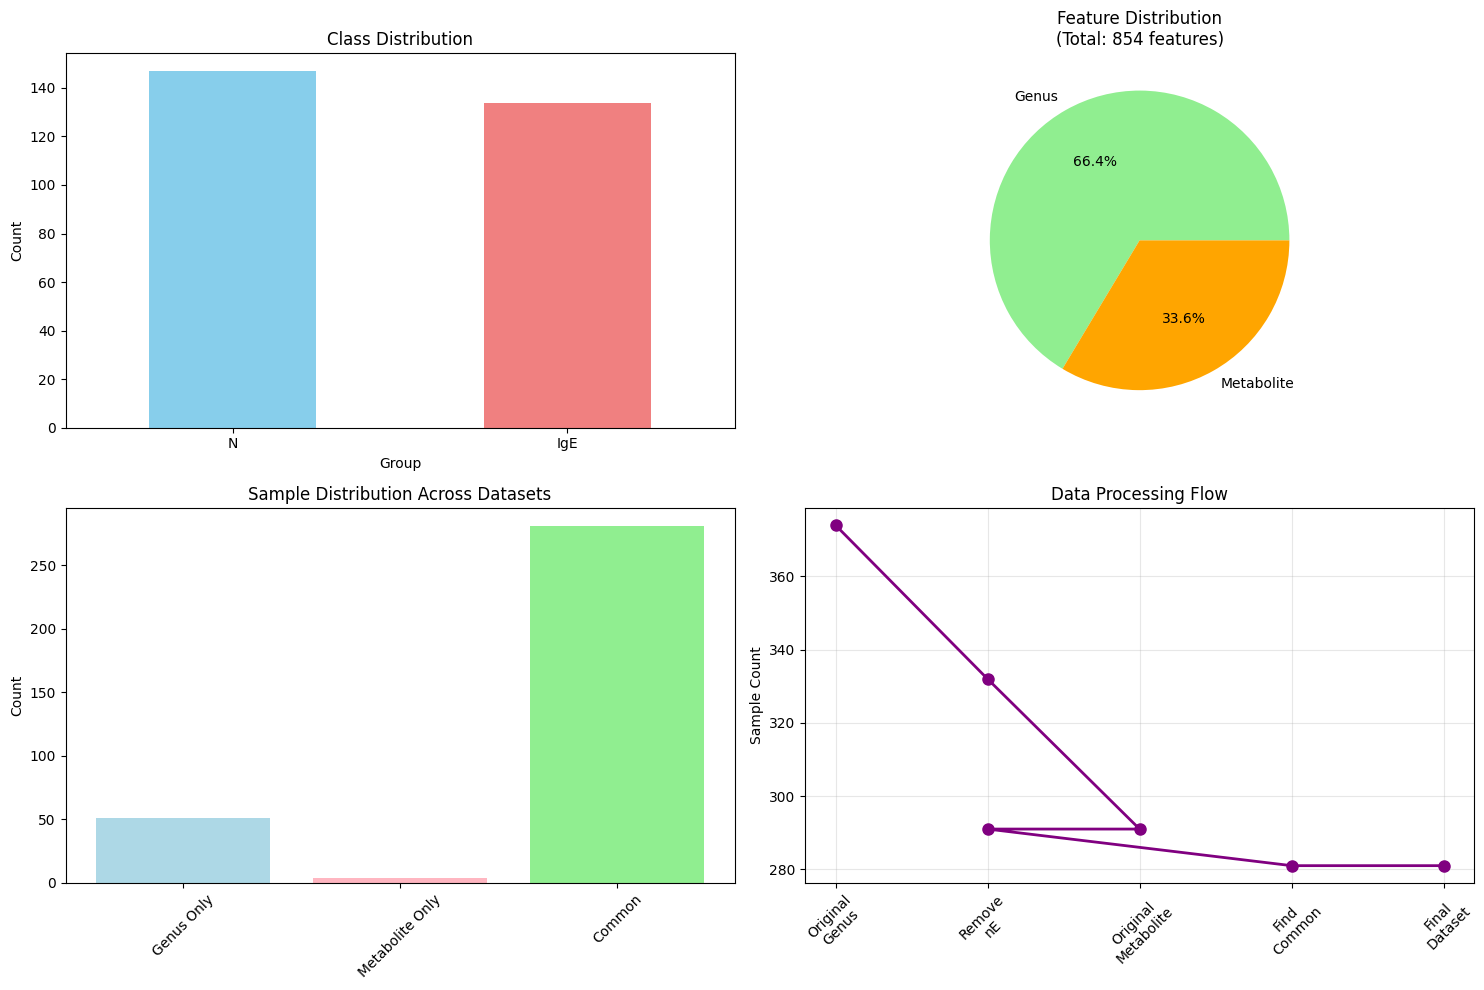


Visualization saved as 'genus_metabolite_115_203_processing_summary.png'


In [56]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Class distribution
groups.value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'lightcoral'])
axes[0,0].set_title('Class Distribution')
axes[0,0].set_xlabel('Group')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=0)

# Feature distribution (genus vs metabolite)
feature_types = ['Genus', 'Metabolite']
feature_counts = [len(genus_features), len(metabolite_features)]
axes[0,1].pie(feature_counts, labels=feature_types, autopct='%1.1f%%', colors=['lightgreen', 'orange'])
axes[0,1].set_title(f'Feature Distribution\n(Total: {sum(feature_counts)} features)')

# Sample distribution across datasets
sample_info = pd.DataFrame({
    'Dataset': ['Genus Only', 'Metabolite Only', 'Common'],
    'Count': [len(genus_only), len(metabolite_only), len(common_samples)]
})
axes[1,0].bar(sample_info['Dataset'], sample_info['Count'], color=['lightblue', 'lightpink', 'lightgreen'])
axes[1,0].set_title('Sample Distribution Across Datasets')
axes[1,0].set_ylabel('Count')
axes[1,0].tick_params(axis='x', rotation=45)

# Data processing flow
steps = ['Original\nGenus', 'Remove\nnE', 'Original\nMetabolite', 'Remove\nnE', 'Find\nCommon', 'Final\nDataset']
counts = [genus_data.shape[1], genus_clean.shape[1], metabolite_data.shape[1], 
          metabolite_clean.shape[1], len(common_samples), combined_data.shape[0]]
axes[1,1].plot(steps, counts, marker='o', linewidth=2, markersize=8, color='purple')
axes[1,1].set_title('Data Processing Flow')
axes[1,1].set_ylabel('Sample Count')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('genus_metabolite_115_203_processing_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'genus_metabolite_115_203_processing_summary.png'")

## 13. Prepare Data for Machine Learning

In [57]:
# Prepare data for machine learning
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(f"IgE: {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"N: {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"\nTest set class distribution:")
print(f"IgE: {sum(y_test == 1)} ({sum(y_test == 1)/len(y_test)*100:.1f}%)")
print(f"N: {sum(y_test == 0)} ({sum(y_test == 0)/len(y_test)*100:.1f}%)")

# Save train/test splits
X_train.to_excel('X_train_genus_metabolite_115_203.xlsx')
X_test.to_excel('X_test_genus_metabolite_115_203.xlsx')
pd.DataFrame({'label': y_train}, index=X_train.index).to_excel('y_train_genus_metabolite_115_203.xlsx')
pd.DataFrame({'label': y_test}, index=X_test.index).to_excel('y_test_genus_metabolite_115_203.xlsx')

print("\nTrain/test splits saved!")

Training set: 224 samples
Test set: 57 samples

Training set class distribution:
IgE: 107 (47.8%)
N: 117 (52.2%)

Test set class distribution:
IgE: 27 (47.4%)
N: 30 (52.6%)

Train/test splits saved!

Train/test splits saved!


In [58]:
# Specific dataset split method (based on the metabolite_data_source 115 or 203)
# 115 as training set, 203 as test set

print("=== IMPLEMENTING DATA SOURCE BASED TRAIN/TEST SPLIT ===")

# First, check if we have metabolite_data_source in our combined data
if 'metabolite_data_source' in combined_data.columns:
    print("Found metabolite_data_source column in combined_data")
    data_source_col = 'metabolite_data_source'
elif 'metabolite_data_source' in X.columns:
    print("Found metabolite_data_source column in X")
    data_source_col = 'metabolite_data_source'
else:
    # Check for any column that might contain data source information
    potential_cols = [col for col in combined_data.columns if 'data_source' in col.lower()]
    print(f"Available columns containing 'data_source': {potential_cols}")
    
    if potential_cols:
        data_source_col = potential_cols[0]
        print(f"Using {data_source_col} as data source column")
    else:
        print("ERROR: No data source column found!")
        print("Available columns in combined_data:")
        print(list(combined_data.columns))
        data_source_col = None

if data_source_col:
    # Check unique values in data source column
    unique_sources = combined_data[data_source_col].unique()
    print(f"Unique data sources: {unique_sources}")
    
    # Get indices for 115 (training) and 203 (test) - updated to match actual values
    train_indices = combined_data[combined_data[data_source_col] == '115_samples'].index
    test_indices = combined_data[combined_data[data_source_col] == '203_samples'].index
    
    print(f"\nData source distribution:")
    print(f"115_samples (for training): {len(train_indices)}")
    print(f"203_samples (for testing): {len(test_indices)}")
    
    if len(train_indices) == 0 or len(test_indices) == 0:
        print("WARNING: Some data sources have no samples!")
        print("Data source value counts:")
        print(combined_data[data_source_col].value_counts())
    else:
        # Create training and testing sets based on data source
        # Remove the data_source column from features for ML
        X_source_based = X.drop(columns=[col for col in X.columns if 'data_source' in col.lower()], errors='ignore')
        
        X_train_115 = X_source_based.loc[train_indices]
        X_test_203 = X_source_based.loc[test_indices]
        y_train_115 = y.loc[train_indices]
        y_test_203 = y.loc[test_indices]
        
        print(f"\n=== SOURCE-BASED SPLIT RESULTS ===")
        print(f"Training set (115): {X_train_115.shape[0]} samples, {X_train_115.shape[1]} features")
        print(f"Test set (203): {X_test_203.shape[0]} samples, {X_test_203.shape[1]} features")
        
        # Check class distribution in both sets
        print(f"\nTraining set (115) class distribution:")
        train_groups_115 = combined_data.loc[train_indices, 'group']
        print(f"IgE: {sum(y_train_115 == 1)} ({sum(y_train_115 == 1)/len(y_train_115)*100:.1f}%)")
        print(f"N: {sum(y_train_115 == 0)} ({sum(y_train_115 == 0)/len(y_train_115)*100:.1f}%)")
        
        print(f"\nTest set (203) class distribution:")
        test_groups_203 = combined_data.loc[test_indices, 'group']
        print(f"IgE: {sum(y_test_203 == 1)} ({sum(y_test_203 == 1)/len(y_test_203)*100:.1f}%)")
        print(f"N: {sum(y_test_203 == 0)} ({sum(y_test_203 == 0)/len(y_test_203)*100:.1f}%)")
        
        # Save the source-based splits
        X_train_115.to_excel('X_train_source115_genus_metabolite.xlsx')
        X_test_203.to_excel('X_test_source203_genus_metabolite.xlsx')
        pd.DataFrame({'label': y_train_115}, index=X_train_115.index).to_excel('y_train_source115_genus_metabolite.xlsx')
        pd.DataFrame({'label': y_test_203}, index=X_test_203.index).to_excel('y_test_source203_genus_metabolite.xlsx')
        
        print(f"\nSource-based splits saved:")
        print("- X_train_source115_genus_metabolite.xlsx (115 as training)")
        print("- X_test_source203_genus_metabolite.xlsx (203 as testing)")
        print("- y_train_source115_genus_metabolite.xlsx")
        print("- y_test_source203_genus_metabolite.xlsx")
        
        print(f"\nThis provides a true cross-dataset validation:")
        print(f"- Model trained on 115 dataset samples")
        print(f"- Model tested on 203 dataset samples")
        print(f"- Tests generalization across different data collection batches")
        
        # Compare with random split approach
        print(f"\n=== COMPARISON WITH RANDOM SPLIT ===")
        print(f"Random split (previous method):")
        print(f"  - Training: {X_train.shape[0]} samples")
        print(f"  - Testing: {X_test.shape[0]} samples")
        print(f"Source-based split (new method):")
        print(f"  - Training (115): {X_train_115.shape[0]} samples")
        print(f"  - Testing (203): {X_test_203.shape[0]} samples")
        
else:
    print("Cannot proceed without data source information!")

=== IMPLEMENTING DATA SOURCE BASED TRAIN/TEST SPLIT ===
Found metabolite_data_source column in combined_data
Unique data sources: ['203_samples' '115_samples']

Data source distribution:
115_samples (for training): 108
203_samples (for testing): 173

=== SOURCE-BASED SPLIT RESULTS ===
Training set (115): 108 samples, 853 features
Test set (203): 173 samples, 853 features

Training set (115) class distribution:
IgE: 50 (46.3%)
N: 58 (53.7%)

Test set (203) class distribution:
IgE: 84 (48.6%)
N: 89 (51.4%)

Source-based splits saved:
- X_train_source115_genus_metabolite.xlsx (115 as training)
- X_test_source203_genus_metabolite.xlsx (203 as testing)
- y_train_source115_genus_metabolite.xlsx
- y_test_source203_genus_metabolite.xlsx

This provides a true cross-dataset validation:
- Model trained on 115 dataset samples
- Model tested on 203 dataset samples
- Tests generalization across different data collection batches

=== COMPARISON WITH RANDOM SPLIT ===
Random split (previous method):
  

## Summary

This notebook has successfully:

1. **Loaded the data**: 
   - Genus data (tab-separated .xls file)
   - Merged metabolite data (115+203 combined, .xlsx file)

2. **Removed duplicates**: Eliminated nE samples from both datasets

3. **Found common samples**: Identified samples present in both datasets

4. **Created labels**: IgE = 1 (allergy positive), N = 0 (allergy negative)

5. **Combined datasets**: 
   - Added **genus_** prefix to all genus features
   - Added **metabolite_** prefix to all metabolite features
   - Merged both feature sets

6. **Quality checks**: Verified data integrity

7. **Saved processed data**: 
   - **Main output**: `genus_metabolite_115_203_merged_ml_format.xlsx`
   - Additional files for convenience

8. **Prepared ML data**: Train/test splits ready for modeling

**Key Features:**
- **500+** genus features (prefixed with `genus_`)
- **Multiple** metabolite features (prefixed with `metabolite_`)
- Clear distinction between feature types through prefixes
- Ready for multi-modal machine learning analysis

The processed data is now ready for allergy prediction modeling with expanded feature set!